In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
!pip install -U tensorflow==2.0.0-alpha0
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

     |████████████████████████████████| 79.9MB 46.8MB/s 
     |████████████████████████████████| 419kB 35.2MB/s 
     |████████████████████████████████| 3.0MB 35.9MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


Using TensorFlow backend.


../input/fordham-cs6000-hw/mnist_data/mnist.trainlabel.npy
../input/fordham-cs6000-hw/mnist_data/mnist.train.npy
../input/fordham-cs6000-hw/mnist_data/mnist.test.npy
../input/fordham-cs6000-hw/mnist_data/sample_submission.csv


In [2]:
x_train = np.load("../input/fordham-cs6000-hw/mnist_data/mnist.train.npy")
np.max(x_train) # Our data is already normalized

1.0

In [3]:
y_train = np.load("../input/fordham-cs6000-hw/mnist_data/mnist.trainlabel.npy")
y_train # We will use one-hot encoding to convert values (0-9) to binary values

array([5, 5, 9, ..., 8, 0, 7])

In [4]:
x_test = np.load("../input/fordham-cs6000-hw/mnist_data/mnist.test.npy")
np.max(x_test)

1.0

In [5]:
y_test = pd.read_csv("../input/fordham-cs6000-hw/mnist_data/sample_submission.csv", usecols = ['class'])
y_test.head()

,class
0,7
1,4
2,3
3,5
4,7


In [6]:
# Convert y_test from DataFrame to Numpy Array
y_test = y_test.to_numpy()

In [7]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [8]:
# Printing dimensions of our x_train and y_train
print("x_train size:", x_train.shape) # 56,000 images, each image of 28px by 28px
print("y_train size:", y_train.shape) # total classes (0-9 digits)
print("x_test size:", x_test.shape) # 28,000 images, each image of 28px by 28px

x_train size: (56000, 28, 28)
y_train size: (56000, 1)
x_test size: (28000, 28, 28)


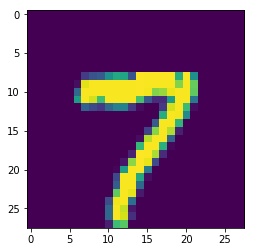

In [9]:
plt.imshow(x_train[4])
plt.show()

2.One hot encode the labels - scaling the values between 0 and 1.

In [10]:
# one-hot encoding using keras' numpy-related utilities
from keras.utils import np_utils

n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)

Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test =  np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (56000, 1)
Shape after one-hot encoding:  (56000, 10)


3. Convert each image matrix ( 28×28 ) to an array ( 28*28 = 784 dimenstional ) which will be fed to the network as a single feature.

In [11]:
# Change from matrix to array of dimension 28x28 to array of dimension 784
dim_data = np.prod(x_train.shape[1:])
X_train = x_train.reshape(x_train.shape[0], dim_data)
X_test = x_test.reshape(x_test.shape[0], dim_data) 

In [12]:
print("x_train size:", X_train.shape) 
print("x_test size:", X_test.shape)

x_train size: (56000, 784)
x_test size: (28000, 784)


4. Split training data into a train and validation set.

In [13]:
# Train and validation split (80% train, 20% val)
X_train, X_val = X_train[:-11200], X_train[-11200:]
Y_train, Y_val = Y_train[:-11200], Y_train[-11200:]

print("x_train size:", X_train.shape) 
print("y_train size:", Y_train.shape) 
print("x_val size:", X_val.shape)
print("y_val size:", Y_val.shape)

x_train size: (44800, 784)
y_train size: (44800, 10)
x_val size: (11200, 784)
y_val size: (11200, 10)


### We want to build a 784(Input)-784(Hidden Layer1)-256(Hidden Layer2)-10(Output) neural net model.


In [14]:
h1_size = 784
h2_size = 256
h3_size = 10
input_size = 784
n_samples = X_train.shape[0]

# Initialize weights and bias
w1 = np.zeros((input_size, h1_size)) + (1/n_samples) # This weight initialization produced bad results
b1 = np.zeros((h1_size,1)) 
w2 = np.zeros((h1_size, h2_size)) + (1/n_samples)
b2 = np.zeros((h2_size,1))
w3 = np.zeros((h2_size, h3_size)) + (1/n_samples)
b3 = np.zeros((h3_size,1)) 

In [15]:
print(b1.shape, b2.shape, b3.shape)

(784, 1) (256, 1) (10, 1)


In [16]:
# Define the softmax activation function
# The softmax function will be used only for the output layer activations
def softmax(a):
    a = a-a.max() # to avoid numerical overflow
    exp_a = np.exp(a)
    return exp_a/exp_a.sum(axis=1, keepdims=True) # produces an output between 0 and 1
# ______________________________________________________________________________________
# Define our activation functions and their derivates, using numpy
def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2
# ______________________________________________________________________________________
# Cross-Entropy function 
def cross_entropy(Y_train, ab3, N):
    """Y_train: vector of the actual output
        a3: vector of the final output predictions
        N: number of samples to divide by"""
    log_prob = np.multiply(np.log(ab3), Y_train)
    cost = - np.sum(log_prob) / N
    return cost

In [17]:
def forward(x_train):
    # Implement forward propagation 
    z1 = np.dot(x_train, w1) + b1.T
    a1 = np.tanh(z1)
    
    z2 = np.dot(a1,w2) + b2.T
    a2 = np.tanh(z2)
    
    z3 = np.dot(a2, w3) + b3.T
    a3 = softmax(z3) # final output prediction
    
    return z1, a1, z2, a2, z3, a3

In [18]:
z1, a1, z2, a2, z3, a3 = forward(X_train)

In [19]:
# Compute the cross-entropy 
cross_entropy(Y_train, a3, n_samples)

2.302585092994045

In [20]:
# Back propagation
def backward(z1, a1, z2, a2, z3, a3, x_train, y_train):
    dz3 = a3 - y_train
#     print(dz3.shape)
    dw3 = (1/n_samples) * np.dot(a2.T, dz3)
#     print(dw3.shape)
    db3 = (1/n_samples) * np.sum(dz3.T, axis=1, keepdims=True)
#     print(db3.shape)
    dz2 = np.multiply(np.dot(dz3, w3.T), 1 - np.power(a2, 2))

    dw2 = (1/n_samples) * np.dot(a1.T, dz2)
    db2 = (1/n_samples) * np.sum(dz2.T, axis=1, keepdims=True)
#     print(db2.shape)
    dz1 = np.multiply(np.dot(dz2, w2.T), 1 - np.power(a1, 2))
    dw1 = (1/n_samples) * np.dot(x_train.T, dz1)
    db1 = (1/n_samples) * np.sum(dz1.T, axis=1, keepdims=True)
    
    return dw3, db3, dw2,  db2, dw1, db1

In [21]:
dw3, db3, dw2,  db2, dw1, db1 = backward(z1, a1, z2, a2, z3, a3, X_train, Y_train)

In [22]:
# Update Weighs and Biases
learning_rate = 0.01

w1 = w1 - learning_rate * dw1
b1 = b1 - learning_rate * db1
w2 = w2 - learning_rate * dw2
b2 = b2 - learning_rate * db2
w3 = w3 - learning_rate * dw3
b3 = b3 - learning_rate * db3

In [23]:
n_samples = 44800
batchSz = 32
batchNum = int(n_samples/batchSz)
n_epoches = 1
learning_rate = 0.1

for k in range(0, n_epoches):
    for i in range(batchNum):

        # mini batch
        imgs = X_train[i*batchSz: (i+1)*batchSz]
        anss = Y_train[i*batchSz: (i+1)*batchSz]

        # forward
        z1, a1, z2, a2, z3, a3 = forward(imgs)

        # backward
        dw3, db3, dw2, db2, dw1, db1 = backward(z1, a1, z2, a2, z3, a3, imgs, anss)

        # Update the weights and bias
        w1 = w1 - learning_rate * dw1
        b1 = b1 - learning_rate * db1
        w2 = w2 - learning_rate * dw2
        b2 = b2 - learning_rate * db2
        w3 = w3 - learning_rate * dw3
        b3 = b3 - learning_rate * db3

        # print xentropy each 100 minibatches
        if i%50 == 0:
            zb1, ab1, zb2, ab2, zb3, ab3 = forward(X_train)
            cross_entropy(Y_train, ab3, n_samples)
#             print(xentropy)


>  The code below was inpsired from Python Machine Learning - Sebastian Raschka and Vahid Mirjalili

In [24]:
class NeuralNet_Version2(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : Number of hidden units.(int)
    L2 : Lambda value for L2-regularization. (float - default: 0.)
    epochs : Number of passes over the training set.(int - default: 50) 
    eta : Learning rate. (float - default: 0.01)
    shuffle : Shuffles training data every epoch if True to prevent circles. (bool - default: True)
    minibatch_size : Number of training samples per minibatch when splitting the training data 
                    in each epoch for stochastic gradient descent. (int - default: 32)
    seed : Random seed for initalizing weights and shuffling. (int - default: 2205)
        
    Attributes
    -----------
    eval_ : Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden_1=784, n_hidden_2=256, epochs=1, lr=0.01, lambd=1,
                 shuffle=True, minibatch_size=32, seed=2205):

        self.random = np.random.RandomState(seed)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.epochs = epochs
        self.lr = lr
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.lambd = lambd

    def _tanh(self, z):
        """Compute tanh activation function"""
        return np.tanh(z)
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _sigmoid_derivative(self, z):
        return self._sigmoid(z) * (1 - self._sigmoid(z))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        z_h1 = np.dot(X, self.w_h1) + self.b_h1

        # step 2: activation of hidden layer 1
        a_h1 = self._tanh(z_h1)
#         a_h1 = self._sigmoid(z_h1)
        
        # step 3: net input of hidden layer 2        
        z_h2 = np.dot(X, self.w_h2) + self.b_h2
        
        # step 4: activation of hidden layer 2        
        a_h2 = self._tanh(z_h2)
#         a_h2 = self._sigmoid(z_h2)
        

        # step 5: net input of output layer
        z_out = np.dot(a_h2, self.w_out) + self.b_out

        # step 6: activation output layer
        a_out = self._softmax(z_out)

        return z_h1, a_h1, z_h2, a_h2, z_out, a_out

    
    def _backward(self, activation):
        
        return None
    

    def _softmax(self, a):
        """Takes an N-dimensional vector of real numbers and 
        transforms it into a vector in range (0,1) which add up to 1."""
        a = a-a.max() # to avoid numerical overflow
        exp_a = np.exp(a)
        return exp_a/exp_a.sum(axis=1, keepdims=True)
    
    def _cross_entropy(self, y_pred, y_true):
        """Compute cross entropy loss with softmax.

        Parameters
        ----------
        y_true : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        y_pred : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        loss : (float)
        """
        
#         log_prob = np.multiply(np.log(y_pred), y_true)
        cost = - np.sum(y_true * np.log(y_pred))/44800 + \
                (np.sum(np.square(self.w_h1)) + np.sum(np.square(self.w_h2)) + np.sum(np.square(self.w_out)))*(self.lambd/(2*44800))


        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        z_h1, a_h1, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(a_out, axis=1)
        return y_pred

    def fit(self, X_train, Y_train, X_valid, Y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self
        """
        
        # number of neurons for input and output layer
        outSz = Y_train.shape[1]  # number of class labels, 10
        inSz = X_train.shape[1] # 784
        N = X_train.shape[0] # total number of instances in the training data
        
        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden1
        self.b_h1 = np.random.rand(self.n_hidden_1) 
        self.w_h1 = np.random.rand(inSz, self.n_hidden_1)/np.sqrt(1/inSz)
        
        # weights for hidden1 -> hidden2
        
        self.b_h2 = np.zeros(self.n_hidden_2) 
        self.w_h2 = np.random.rand(self.n_hidden_1, self.n_hidden_2)/np.sqrt(1/inSz)
        

        # weights for hidden2 -> output
        self.b_out = np.zeros(outSz)
        self.w_out = np.random.rand(self.n_hidden_2, outSz)/np.sqrt(1/inSz)

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h1, a_h1, z_h2, a_h2, z_out, a_out = self._forward(X_train[batch_idx])
                
#                 print(z_h1, a_h1, z_h2, a_h2, z_out, a_out)

                
                ##################
                # Backpropagation
                ##################
                
                div = 1/32
                
                
                # 
                dz_out = a_out - Y_train[batch_idx] # [32,10] -[32,10]
                dw_out = div * np.matmul(a_h2.T, dz_out ) + (self.lambd/32)*self.w_out # [256,10] = [256,32]*[32,10]
                db_out = div * dz_out # [32, 10]

                dz_h2 = np.matmul(dz_out, self.w_out.T) * (1 - np.power(a_h2, 2)) # [32,256] = [32,10]*[256,10]
                dw_h2 = div * np.matmul( a_h1.T, dz_h2) + (self.lambd/32)*self.w_h2 # [784, 256] = [784,32]*[32*256]
                db_h2 = div * dz_h2            
            
                dz_h1 = np.matmul(dz_h2, self.w_h2.T ) * (1 - np.power(a_h1, 2)) # [32,784] = 
                dw_h1 = div * np.matmul(X_train[batch_idx].T, dz_h1) + (self.lambd/32)*self.w_h1 # [784, 784] = [784,32] * [32, 784]
                db_h1 = div * dz_h1 
                         
                # weight updates

                self.w_h1 -= self.lr * (dw_h1) # [784, 784]
                self.b_h1 -= self.lr * db_h1.sum(axis=0)
                
                self.w_h2 -= self.lr * (dw_h2) # [784, 256]
                self.b_h2 -= self.lr * db_h2.sum(axis=0)
                
                self.w_out -= self.lr * (dw_out) # [256, 10]
                self.b_out -= self.lr * db_out.sum(axis=0)
                

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h1, a_h1, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            cost = self._cross_entropy(y_pred=a_out, y_true=Y_train)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            

            
            train_acc = np.sum(y_train_pred == np.argmax(Y_train))/X_train.shape[0]

            valid_acc = np.sum(y_valid_pred == np.argmax(Y_valid))/X_valid.shape[0]

            print('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [25]:
class NeuralNet(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : Number of hidden units.(int)
    L2 : Lambda value for L2-regularization. (float - default: 0.)
    epochs : Number of passes over the training set.(int - default: 50) 
    eta : Learning rate. (float - default: 0.01)
    shuffle : Shuffles training data every epoch if True to prevent circles. (bool - default: True)
    minibatch_size : Number of training samples per minibatch when splitting the training data 
                    in each epoch for stochastic gradient descent. (int - default: 32)
    seed : Random seed for initalizing weights and shuffling. (int - default: 2205)
        
    Attributes
    -----------
    eval_ : Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden_1=784, n_hidden_2=256, epochs=1, lr=0.01,
                 shuffle=True, minibatch_size=32, seed=2205):

        self.random = np.random.RandomState(seed)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.epochs = epochs
        self.lr = lr
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _tanh(self, z):
        """Compute tanh activation function"""
        return np.tanh(z)
    
    def _tanh_deriv(self, z):
        return 1.0 - np.tanh(z)**2
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _sigmoid_derivative(self, z):
        return self._sigmoid(z) * (1 - self._sigmoid(z))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        z_h1 = np.dot(X, self.w_h1) + self.b_h1

        # step 2: activation of hidden layer 1
        a_h1 = self._tanh(z_h1)
#         a_h1 = self._sigmoid(z_h1)
        
        # step 3: net input of hidden layer 2        
        z_h2 = np.dot(X, self.w_h2) + self.b_h2
        
        # step 4: activation of hidden layer 2        
        a_h2 = self._tanh(z_h2)
#         a_h2 = self._sigmoid(z_h2)

        # step 5: net input of output layer
        z_out = np.dot(a_h2, self.w_out) + self.b_out

        # step 6: activation output layer
        a_out = self._softmax(z_out)

        return z_h1, a_h1, z_h2, a_h2, z_out, a_out


    def _softmax(self, a):
        """Takes an N-dimensional vector of real numbers and 
        transforms it into a vector in range (0,1) which add up to 1."""
        a = a-a.max() # to avoid numerical overflow
        exp_a = np.exp(a)
        return exp_a/exp_a.sum(axis=1, keepdims=True)
    
    def _cross_entropy(self, y_pred, y_true, N):
        """Compute cross entropy loss with softmax.

        Parameters
        ----------
        y_true : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        y_pred : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        loss : (float)
        """
        log_prob = np.multiply(np.log(y_pred), y_true)
        cost = - np.sum(log_prob) / N
        
#         log_prob = y_true * np.log(y_pred)
#         cost = - np.sum(log_prob)

        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        z_h1, a_h1, z_h2, a_h2, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self
        """
        
        # number of neurons for input and output layer
        outSz = y_train.shape[1]  # number of class labels, 10
        inSz = X_train.shape[1] # 784
        N = X_train.shape[0] # total number of instances in the training data
        
        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden1
        self.b_h1 = np.random.rand(self.n_hidden_1) 
        self.w_h1 = np.random.rand(inSz, self.n_hidden_1)/N
        
        # weights for hidden1 -> hidden2
        
        self.b_h2 = np.zeros(self.n_hidden_2) 
        self.w_h2 = np.random.rand(self.n_hidden_1, self.n_hidden_2)/N

        # weights for hidden2 -> output
        self.b_out = np.zeros(outSz)
        self.w_out = np.random.rand(self.n_hidden_2, outSz)/N

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h1, a_h1, z_h2, a_h2, z_out, a_out = self._forward(X_train[batch_idx])
#                 print(z_h1, a_h1, z_h2, a_h2, z_out, a_out)

                ##################
                # Backpropagation
                ##################
                
                div = 1
                
                dz_out = a_out - y_train[batch_idx]
                dw_out = div * np.dot(a_h2.T, dz_out)
                db_out = div * dz_out
    
                dz_h2 = np.multiply(np.dot(dz_out, self.w_out.T), self._tanh_deriv(a_h2))
                dw_h2 = div * np.dot(a_h1.T, dz_h2)
                db_h2 = div * dz_h2        
            
                dz_h1 = np.multiply(np.dot(dz_h2, self.w_h2.T), self._tanh_deriv(a_h1))
                dw_h1 = div * np.dot(X_train[batch_idx].T, dz_h1)
                db_h1 = div * dz_h1
                         
                # weight updates

                self.w_h1 -= self.lr * (dw_h1) 
                self.b_h1 -= self.lr * db_h1.sum(axis=0)
                
                self.w_h2 -= self.lr * (dw_h2) 
                self.b_h2 -= self.lr * db_h2.sum(axis=0)
                
                self.w_out -= self.lr * (dw_out)
                self.b_out -= self.lr * db_out.sum(axis=0)

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h1, a_h1, z_h2, a_h2, z_out, a_out = self._forward(X_train)
            cost = self._cross_entropy(y_pred=a_out, y_true=y_train, N=N)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            
            train_acc = np.sum(y_train_pred == np.argmax(y_train, 1))/N
    
            valid_acc = np.sum(y_valid_pred == np.argmax(y_valid, 1))/N

#             print(y_train_pred.shape, y_train.shape)

#             print(train_acc, valid_acc)

            print('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [26]:
NN_V2 = NeuralNet_Version2(n_hidden_1=784, n_hidden_2=256, epochs=50, lr=0.01, lambd=1, shuffle=True, minibatch_size=32, seed=2205)

In [27]:
NN_V2.fit(X_train, Y_train, X_val, Y_val)

01/50 | Cost: 995.82 | Train/Valid Acc.: 0.00%/100.00% 
02/50 | Cost: 416.42 | Train/Valid Acc.: 0.00%/100.00% 
03/50 | Cost: 174.92 | Train/Valid Acc.: 0.00%/0.00% 
04/50 | Cost: 74.25 | Train/Valid Acc.: 0.00%/0.00% 
05/50 | Cost: 32.31 | Train/Valid Acc.: 0.00%/0.00% 
06/50 | Cost: 14.81 | Train/Valid Acc.: 0.00%/0.00% 
07/50 | Cost: 7.54 | Train/Valid Acc.: 0.00%/0.00% 
08/50 | Cost: 4.49 | Train/Valid Acc.: 0.00%/0.00% 
09/50 | Cost: 3.23 | Train/Valid Acc.: 0.00%/0.00% 
10/50 | Cost: 2.69 | Train/Valid Acc.: 0.00%/0.00% 
11/50 | Cost: 2.47 | Train/Valid Acc.: 0.00%/0.00% 
12/50 | Cost: 2.40 | Train/Valid Acc.: 0.00%/0.00% 
13/50 | Cost: 2.36 | Train/Valid Acc.: 0.00%/0.00% 
14/50 | Cost: 2.30 | Train/Valid Acc.: 0.00%/0.00% 
15/50 | Cost: 2.15 | Train/Valid Acc.: 0.00%/2.74% 
16/50 | Cost: 2.08 | Train/Valid Acc.: 5.87%/9.67% 
17/50 | Cost: 1.97 | Train/Valid Acc.: 0.00%/0.00% 
18/50 | Cost: 1.83 | Train/Valid Acc.: 0.36%/9.76% 
19/50 | Cost: 1.69 | Train/Valid Acc.: 7.59%/10.38%

In [28]:
NN = NeuralNet(n_hidden_1=784, n_hidden_2=256, epochs=50, lr=0.01, shuffle=True, minibatch_size=32, seed=2205)

In [29]:
# NN.fit(X_train, Y_train, X_val, Y_val)

In [30]:
y_pred = NN_V2.predict(X_test)

In [31]:
type(y_pred)

numpy.ndarray

In [32]:
# Convert y_pred 1D Numpy Array to List
y_pred = y_pred.tolist()

# # # Flatten list of lists
# # Q3_pred_flat = list(np.concatenate(Q3_pred))

y_pred = pd.DataFrame({"Y_Pred": y_pred})
y_pred.head()

,Y_Pred
0,1
1,6
2,7
3,7
4,1


In [33]:
# Save predictions to CSV file
y_pred.to_csv('Q3_prediction.csv')

### Tensorflow

In [34]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [35]:
# Define initialization parameters for our model.
num_classes = 10
num_features = X_train.shape[1] # 784
num_output = 10
num_layers_1 = 784
num_layers_2 = 256
learning_rate = 0.01

print(num_features)

784


> Reference: Videos from data camp - https://www.datacamp.com/courses/deep-learning-with-keras-in-python

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import optimizers
import timeit

In [37]:
import random 

def seed_everything(SEED=2205):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
    
seed_everything(2205)

In [38]:
# Initialize the constructor
model = Sequential()

# Add an input layer with 784 neurons and tanh activation
model.add(Dense(num_features, activation='tanh', input_shape=(num_features,)))

# Add one hidden layer with 256 neurons and tanh activation
model.add(Dense(num_layers_2, activation='tanh'))

# Add an output layer with 10 neurons and softmax activation 
model.add(Dense(num_output, activation='softmax'))

#Compiling the sequential model 
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# model.optimizer.get_config()

# {'name': 'Adam',
#  'learning_rate': 0.01,
#  'decay': 0.0,
#  'beta_1': 0.9,
#  'beta_2': 0.999,
#  'epsilon': 1e-07,
#  'amsgrad': False}

Once we compiled our model we can start the training process. We want to iterate on the whole training set (epochs = 50) and specify number of samples to use for one update to the model's weights (batch size). Generally the bigger the batch, the more stable our stochastic.

In [40]:
# Start running time
start = timeit.default_timer()

# Train the model for 50 epochs and save metrics in metrics
metrics = model.fit(X_train, Y_train,
          batch_size=32, epochs=50,
          validation_data=(X_val, Y_val))

# Stop running time
stop = timeit.default_timer()

print("Time: ", stop - start)

Train on 44800 samples, validate on 11200 samples
Epoch 1/50
44800/44800 [==============================] - 9s 205us/sample - loss: 0.5066 - accuracy: 0.8460 - val_loss: 0.6247 - val_accuracy: 0.8151
Epoch 2/50
44800/44800 [==============================] - 10s 216us/sample - loss: 0.6177 - accuracy: 0.8074 - val_loss: 0.5418 - val_accuracy: 0.8266
Epoch 3/50
44800/44800 [==============================] - 9s 204us/sample - loss: 0.6488 - accuracy: 0.8018 - val_loss: 0.6135 - val_accuracy: 0.8274
Epoch 4/50
44800/44800 [==============================] - 9s 193us/sample - loss: 0.6220 - accuracy: 0.8136 - val_loss: 0.5896 - val_accuracy: 0.8185
Epoch 5/50
44800/44800 [==============================] - 9s 197us/sample - loss: 0.6818 - accuracy: 0.7956 - val_loss: 0.5957 - val_accuracy: 0.8335
Epoch 6/50
44800/44800 [==============================] - 9s 202us/sample - loss: 0.6337 - accuracy: 0.8123 - val_loss: 0.5276 - val_accuracy: 0.8631
Epoch 7/50
44800/44800 [=========================

    Train on 44800 samples, validate on 11200 samples
    Epoch 1/50
    44800/44800 - 7s - loss: 0.5066 - accuracy: 0.8460 - val_loss: 0.6247 - val_accuracy: 0.8151
    Epoch 2/50
    44800/44800 - 7s - loss: 0.6177 - accuracy: 0.8074 - val_loss: 0.5418 - val_accuracy: 0.8266
    Epoch 3/50
    44800/44800 - 7s - loss: 0.6488 - accuracy: 0.8018 - val_loss: 0.6135 - val_accuracy: 0.8274
    Epoch 4/50
    44800/44800 - 7s - loss: 0.6220 - accuracy: 0.8136 - val_loss: 0.5896 - val_accuracy: 0.8185
    Epoch 5/50
    44800/44800 - 7s - loss: 0.6818 - accuracy: 0.7956 - val_loss: 0.5957 - val_accuracy: 0.8335
    Epoch 6/50
    44800/44800 - 7s - loss: 0.6337 - accuracy: 0.8123 - val_loss: 0.5276 - val_accuracy: 0.8631
    Epoch 7/50
    44800/44800 - 7s - loss: 0.6447 - accuracy: 0.8116 - val_loss: 0.5418 - val_accuracy: 0.8435
    Epoch 8/50
    44800/44800 - 7s - loss: 0.6053 - accuracy: 0.8293 - val_loss: 0.5552 - val_accuracy: 0.8512
    Epoch 9/50
    44800/44800 - 7s - loss: 0.5971 - accuracy: 0.8293 - val_loss: 0.5318 - val_accuracy: 0.8557
    Epoch 10/50
    44800/44800 - 7s - loss: 0.5432 - accuracy: 0.8479 - val_loss: 0.4715 - val_accuracy: 0.8632
    Epoch 11/50
    44800/44800 - 7s - loss: 0.6079 - accuracy: 0.8267 - val_loss: 0.6151 - val_accuracy: 0.8227
    Epoch 12/50
    44800/44800 - 7s - loss: 0.6054 - accuracy: 0.8276 - val_loss: 0.7932 - val_accuracy: 0.7508
    Epoch 13/50
    44800/44800 - 7s - loss: 0.6727 - accuracy: 0.8009 - val_loss: 0.6781 - val_accuracy: 0.8034
    Epoch 14/50
    44800/44800 - 7s - loss: 0.5956 - accuracy: 0.8384 - val_loss: 0.5778 - val_accuracy: 0.8352
    Epoch 15/50
    44800/44800 - 7s - loss: 0.5742 - accuracy: 0.8433 - val_loss: 0.5541 - val_accuracy: 0.8484
    Epoch 16/50
    44800/44800 - 7s - loss: 0.5634 - accuracy: 0.8451 - val_loss: 0.6291 - val_accuracy: 0.8196
    Epoch 17/50
    44800/44800 - 7s - loss: 0.5455 - accuracy: 0.8474 - val_loss: 0.5676 - val_accuracy: 0.8285
    Epoch 18/50
    44800/44800 - 7s - loss: 0.5379 - accuracy: 0.8548 - val_loss: 0.4959 - val_accuracy: 0.8719
    Epoch 19/50
    44800/44800 - 7s - loss: 0.5585 - accuracy: 0.8490 - val_loss: 0.5484 - val_accuracy: 0.8553
    Epoch 20/50
    44800/44800 - 7s - loss: 0.5554 - accuracy: 0.8497 - val_loss: 0.6176 - val_accuracy: 0.8368
    Epoch 21/50
    44800/44800 - 7s - loss: 0.5203 - accuracy: 0.8545 - val_loss: 0.5572 - val_accuracy: 0.8153
    Epoch 22/50
    44800/44800 - 7s - loss: 0.5557 - accuracy: 0.8490 - val_loss: 0.5362 - val_accuracy: 0.8467
    Epoch 23/50
    44800/44800 - 7s - loss: 0.5413 - accuracy: 0.8573 - val_loss: 0.4858 - val_accuracy: 0.8728
    Epoch 24/50
    44800/44800 - 7s - loss: 0.5455 - accuracy: 0.8567 - val_loss: 0.6415 - val_accuracy: 0.8429
    Epoch 25/50
    44800/44800 - 7s - loss: 0.5278 - accuracy: 0.8618 - val_loss: 0.5093 - val_accuracy: 0.8704
    Epoch 26/50
    44800/44800 - 7s - loss: 0.5056 - accuracy: 0.8606 - val_loss: 0.6144 - val_accuracy: 0.8446
    Epoch 27/50
    44800/44800 - 7s - loss: 0.4808 - accuracy: 0.8757 - val_loss: 0.4533 - val_accuracy: 0.8815
    Epoch 28/50
    44800/44800 - 7s - loss: 0.5082 - accuracy: 0.8653 - val_loss: 0.5514 - val_accuracy: 0.8621
    Epoch 29/50
    44800/44800 - 7s - loss: 0.5235 - accuracy: 0.8606 - val_loss: 0.4918 - val_accuracy: 0.8768
    Epoch 30/50
    44800/44800 - 7s - loss: 0.4992 - accuracy: 0.8722 - val_loss: 0.5018 - val_accuracy: 0.8729
    Epoch 31/50
    44800/44800 - 7s - loss: 0.4938 - accuracy: 0.8687 - val_loss: 0.4629 - val_accuracy: 0.8822
    Epoch 32/50
    44800/44800 - 7s - loss: 0.5074 - accuracy: 0.8667 - val_loss: 0.4671 - val_accuracy: 0.8607
    Epoch 33/50
    44800/44800 - 7s - loss: 0.5286 - accuracy: 0.8597 - val_loss: 0.4884 - val_accuracy: 0.8599
    Epoch 34/50
    44800/44800 - 8s - loss: 0.5399 - accuracy: 0.8555 - val_loss: 0.5336 - val_accuracy: 0.8609
    Epoch 35/50
    44800/44800 - 8s - loss: 0.5077 - accuracy: 0.8661 - val_loss: 0.4685 - val_accuracy: 0.8759
    Epoch 36/50
    44800/44800 - 7s - loss: 0.5276 - accuracy: 0.8596 - val_loss: 0.4897 - val_accuracy: 0.8731
    Epoch 37/50
    44800/44800 - 7s - loss: 0.4790 - accuracy: 0.8738 - val_loss: 0.4413 - val_accuracy: 0.8777
    Epoch 38/50
    44800/44800 - 7s - loss: 0.4948 - accuracy: 0.8703 - val_loss: 0.6722 - val_accuracy: 0.8543
    Epoch 39/50
    44800/44800 - 7s - loss: 0.5118 - accuracy: 0.8637 - val_loss: 0.4232 - val_accuracy: 0.8964
    Epoch 40/50
    44800/44800 - 7s - loss: 0.5170 - accuracy: 0.8621 - val_loss: 0.4338 - val_accuracy: 0.8854
    Epoch 41/50
    44800/44800 - 7s - loss: 0.4608 - accuracy: 0.8798 - val_loss: 0.3878 - val_accuracy: 0.8975
    Epoch 42/50
    44800/44800 - 7s - loss: 0.4860 - accuracy: 0.8708 - val_loss: 0.4574 - val_accuracy: 0.8884
    Epoch 43/50
    44800/44800 - 7s - loss: 0.4839 - accuracy: 0.8754 - val_loss: 0.5732 - val_accuracy: 0.8547
    Epoch 44/50
    44800/44800 - 7s - loss: 0.4944 - accuracy: 0.8696 - val_loss: 0.5845 - val_accuracy: 0.8628
    Epoch 45/50
    44800/44800 - 7s - loss: 0.4828 - accuracy: 0.8766 - val_loss: 0.6316 - val_accuracy: 0.8579
    Epoch 46/50
    44800/44800 - 7s - loss: 0.4999 - accuracy: 0.8702 - val_loss: 0.5004 - val_accuracy: 0.8771
    Epoch 47/50
    44800/44800 - 7s - loss: 0.4837 - accuracy: 0.8760 - val_loss: 0.4608 - val_accuracy: 0.8861
    Epoch 48/50
    44800/44800 - 7s - loss: 0.4545 - accuracy: 0.8842 - val_loss: 0.5832 - val_accuracy: 0.8506
    Epoch 49/50
    44800/44800 - 7s - loss: 0.4863 - accuracy: 0.8737 - val_loss: 0.4036 - val_accuracy: 0.9029
    Epoch 50/50
    44800/44800 - 7s - loss: 0.4794 - accuracy: 0.8779 - val_loss: 0.4162 - val_accuracy: 0.8987

In [41]:
# Make predictions using X_test
y_pred = model.predict_classes(X_test)

# Reshape predictions array (22800,1)
y_pred = y_pred.reshape(-1,1)

In [42]:
# Convert y_pred 1D Numpy Array to List
y_pred = y_pred.tolist()

# Flatten list of lists
y_pred_flat = list(np.concatenate(y_pred))

predictions = pd.DataFrame({"Y_Pred": y_pred_flat})
predictions.head()

,Y_Pred
0,1
1,2
2,9
3,8
4,5


In [43]:
# evaluate test accuracy before train
score = model.evaluate(X_val, Y_val, batch_size=32)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.3f%%' % accuracy)

11200/11200 [==============================] - 1s 70us/sample - loss: 0.4162 - accuracy: 0.8987
Test accuracy: 89.866%


In [44]:
# Save predictions to CSV file
predictions.to_csv('Q4_prediction.csv')

### Experiment with four optimizers: SGD, Adam, Momentum, and RMSprop

In [45]:
from keras.callbacks import CSVLogger
callbacks = []

# Create csv file to save model results
log1 = CSVLogger('Adam_train_log.csv', append=True, separator=';')
log2 = CSVLogger('SGD_train_log.csv', append=True, separator=';')
log3 = CSVLogger('Momentum_train_log.csv', append=True, separator=';')
log4 = CSVLogger('RMSprop_train_log.csv', append=True, separator=';')

In [46]:
#1) Adam
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Start running time
start = timeit.default_timer()

# Train the model for 50 epochs using Adam optimizer
adam_metrics = model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_val, Y_val), callbacks=[log1])

callbacks.append(CSVLogger(log1))

# Stop running time
stop = timeit.default_timer()

print("Time: ", stop - start) #Time:  404.5758666740003s


Train on 44800 samples, validate on 11200 samples
Epoch 1/50
44800/44800 [==============================] - 9s 206us/sample - loss: 0.4529 - accuracy: 0.8883 - val_loss: 0.5387 - val_accuracy: 0.8662
Epoch 2/50
44800/44800 [==============================] - 9s 197us/sample - loss: 0.4652 - accuracy: 0.8808 - val_loss: 0.4029 - val_accuracy: 0.9042
Epoch 3/50
44800/44800 [==============================] - 9s 193us/sample - loss: 0.4695 - accuracy: 0.8824 - val_loss: 0.4826 - val_accuracy: 0.8888
Epoch 4/50
44800/44800 [==============================] - 9s 192us/sample - loss: 0.4721 - accuracy: 0.8790 - val_loss: 0.5074 - val_accuracy: 0.8792
Epoch 5/50
44800/44800 [==============================] - 9s 190us/sample - loss: 0.4525 - accuracy: 0.8831 - val_loss: 0.4842 - val_accuracy: 0.8756
Epoch 6/50
44800/44800 [==============================] - 9s 190us/sample - loss: 0.4524 - accuracy: 0.8828 - val_loss: 0.7737 - val_accuracy: 0.8178
Epoch 7/50
44800/44800 [==========================

### Adam Optimizer Performance Metrics:

* Overall validation accuracy: 0.9144
* Test accuracy: 0.8938
* Training time: 6.7 mins
* Training loss: 0.4053
* Validation loss: 0.3349

In [47]:
#2) SGD
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0), loss='categorical_crossentropy', metrics=['accuracy'])

# Start running time
start = timeit.default_timer()

# Train the model for 50 epochs using SGD optimizer
sgd_metrics = model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_val, Y_val), callbacks=[log2])

callbacks.append(CSVLogger(log2))

# Stop running time
stop = timeit.default_timer()

print("Time: ", stop - start)

Train on 44800 samples, validate on 11200 samples
Epoch 1/50
44800/44800 [==============================] - 8s 169us/sample - loss: 0.3147 - accuracy: 0.9174 - val_loss: 0.3357 - val_accuracy: 0.9109
Epoch 2/50
44800/44800 [==============================] - 7s 162us/sample - loss: 0.3021 - accuracy: 0.9195 - val_loss: 0.3310 - val_accuracy: 0.9131
Epoch 3/50
44800/44800 [==============================] - 7s 167us/sample - loss: 0.2948 - accuracy: 0.9212 - val_loss: 0.3220 - val_accuracy: 0.9145
Epoch 4/50
44800/44800 [==============================] - 7s 163us/sample - loss: 0.2891 - accuracy: 0.9225 - val_loss: 0.3210 - val_accuracy: 0.9134
Epoch 5/50
44800/44800 [==============================] - 7s 166us/sample - loss: 0.2846 - accuracy: 0.9227 - val_loss: 0.3148 - val_accuracy: 0.9139
Epoch 6/50
44800/44800 [==============================] - 8s 170us/sample - loss: 0.2809 - accuracy: 0.9227 - val_loss: 0.3126 - val_accuracy: 0.9143
Epoch 7/50
44800/44800 [==========================

### SGD Optimizer Performance Metrics:

* Overall validation accuracy: 0.8987
* Test accuracy: 0.8779
* Training time: 9.3 mins
* Training loss: 0.4794
* Validation loss: 0.4162

In [48]:
#3) Momentum
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8), loss='categorical_crossentropy',metrics=['accuracy'])

# Start running time
start = timeit.default_timer()

# Train the model for 50 epochs using SGD Momentum =  0.8
momentum_metrics = model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_val, Y_val), callbacks=[log3])

callbacks.append(CSVLogger(log3))

# Stop running time
stop = timeit.default_timer()

print("Time: ", stop - start) # Time:  363.1876358380032s

Train on 44800 samples, validate on 11200 samples
Epoch 1/50
44800/44800 [==============================] - 8s 189us/sample - loss: 0.2557 - accuracy: 0.9269 - val_loss: 0.2918 - val_accuracy: 0.9162
Epoch 2/50
44800/44800 [==============================] - 8s 188us/sample - loss: 0.2537 - accuracy: 0.9269 - val_loss: 0.2845 - val_accuracy: 0.9182
Epoch 3/50
44800/44800 [==============================] - 8s 184us/sample - loss: 0.2533 - accuracy: 0.9280 - val_loss: 0.2978 - val_accuracy: 0.9143
Epoch 4/50
44800/44800 [==============================] - 9s 212us/sample - loss: 0.2533 - accuracy: 0.9271 - val_loss: 0.2844 - val_accuracy: 0.9155
Epoch 5/50
44800/44800 [==============================] - 10s 218us/sample - loss: 0.2505 - accuracy: 0.9277 - val_loss: 0.2862 - val_accuracy: 0.9168
Epoch 6/50
44800/44800 [==============================] - 10s 223us/sample - loss: 0.2501 - accuracy: 0.9283 - val_loss: 0.2842 - val_accuracy: 0.9179
Epoch 7/50
44800/44800 [========================

### Momentum Optimizer Performance Metrics:

* Overall validation accuracy: 0.9804
* Test accuracy: 1.0000
* Training time: 6.1 mins
* Training loss: 0.0019
* Validation loss: 0.0751

In [49]:
#4) RMSprop
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='categorical_crossentropy',metrics=['accuracy'])

# Start running time
start = timeit.default_timer()

# Train the model for 50 epochs using RMSprop
rmsProp_metrics = model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_val, Y_val), callbacks=[log4])

callbacks.append(CSVLogger(log4))

# Stop running time
stop = timeit.default_timer()

print("Time: ", stop - start) # Time:  626.6540165769984

Train on 44800 samples, validate on 11200 samples
Epoch 1/50
44800/44800 [==============================] - 11s 240us/sample - loss: 0.4042 - accuracy: 0.9110 - val_loss: 0.3487 - val_accuracy: 0.9338
Epoch 2/50
44800/44800 [==============================] - 11s 236us/sample - loss: 0.3971 - accuracy: 0.9166 - val_loss: 0.3861 - val_accuracy: 0.9241
Epoch 3/50
44800/44800 [==============================] - 11s 235us/sample - loss: 0.3953 - accuracy: 0.9225 - val_loss: 0.3389 - val_accuracy: 0.9330
Epoch 4/50
44800/44800 [==============================] - 11s 235us/sample - loss: 0.3757 - accuracy: 0.9246 - val_loss: 0.3593 - val_accuracy: 0.9308
Epoch 5/50
44800/44800 [==============================] - 11s 234us/sample - loss: 0.3777 - accuracy: 0.9252 - val_loss: 0.4089 - val_accuracy: 0.9226
Epoch 6/50
44800/44800 [==============================] - 11s 237us/sample - loss: 0.3666 - accuracy: 0.9289 - val_loss: 0.3629 - val_accuracy: 0.9341
Epoch 7/50
44800/44800 [====================

### RMSprop Optimizer Performance Metrics:

* Overall validation accuracy: 0.9591
* Test accuracy: 0.95585
* Training time: 10.4 mins
* Training loss: 0.2278
* Validation loss: 0.2333

### Image Augmentation

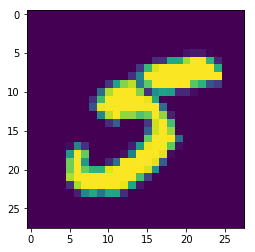

In [50]:
test_image = x_train[0]
plt.imshow(test_image)

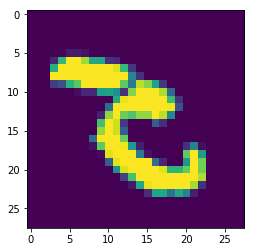

In [51]:
# Flipping images vertically with Numpy
flipped_vertical = np.fliplr(test_image)
plt.imshow(flipped_vertical)

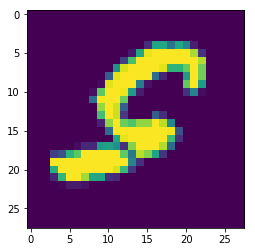

In [52]:
# Flipping images horizontally with Numpy
flipped_horizontal = np.flip(test_image)
plt.imshow(flipped_horizontal)

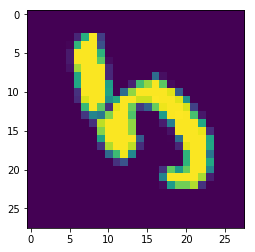

In [53]:
# Rotate imagges 45 degrees, 7 times, clockwise
rotated_img = np.rot90(test_image)
plt.imshow(rotated_img)

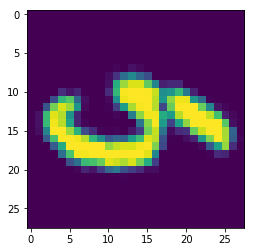

In [54]:
# Rotate images using Scikit-Image: 'angle' = Degrees, 'img' = Input Image
# Rotate imagges 45 degrees, 7 times, counterclockwise = 315 degrees or clockwise = -45 (counterclock)
from skimage import transform

rot1 = transform.rotate(test_image, angle=315)
plt.imshow(rot1)

In [55]:
from skimage import transform

# Store X_train augmented images to list
augmented_images = []

for i in range(x_train.shape[0]):
    flip_v = np.fliplr(x_train[i]) # flips images vertically
    flip_h = np.flip(x_train[i]) # flips images horizontally
    rot1 = transform.rotate(x_train[i], angle=315) # Rotate images 45 degrees = 315 (clockwise) 
    rot2 = transform.rotate(x_train[i], angle=270)
    rot3 = transform.rotate(x_train[i], angle=225)
    rot4 = transform.rotate(x_train[i], angle=180)
    rot5 = transform.rotate(x_train[i], angle=135)
    rot6 = transform.rotate(x_train[i], angle=90)
    rot7 = transform.rotate(x_train[i], angle=45)
    
    # Append all new images to list of augmented_images_Xtrain
    augmented_images.append(flip_v)
    augmented_images.append(flip_h)
    augmented_images.append(rot1)
    augmented_images.append(rot2)
    augmented_images.append(rot3)
    augmented_images.append(rot4)
    augmented_images.append(rot5)
    augmented_images.append(rot6)
    augmented_images.append(rot7)
                              

In [56]:
# Convert list of augmented images to numpy array
aug_train_images_arr = np.asarray(augmented_images)
print(aug_train_images_arr.shape)

(504000, 28, 28)


In [57]:
# Reshape augmented images array to 784
aug_img_train = aug_train_images_arr.reshape(aug_train_images_arr.shape[0], 784)
print(aug_img_train.shape)

(504000, 784)


In [58]:
# Combine augmented images to current training set, X_train
new_Xtrain = np.concatenate((aug_img_train, X_train))
new_Xtrain.shape

(548800, 784)

In [59]:
# Augment the y_train
N = 9 # number of times to clone the y_train array
aug_Ytrain = np.vstack([y_train]*N)

# One-hot enocode aug_Ytrain
n_classes = 10
one_hot_Ytrain = np_utils.to_categorical(aug_Ytrain, n_classes)

# Combine augmented y_train labels to current y_train
new_Ytrain = np.concatenate((one_hot_Ytrain, Y_train))
new_Ytrain.shape

(548800, 10)

In [60]:
# Initialize the constructor
model2 = Sequential()

# Add an input layer with 784 neurons and tanh activation
model2.add(Dense(num_features, activation='tanh', input_shape=(num_features,)))

# Add one hidden layer with 256 neurons and tanh activation
model2.add(Dense(num_layers_2, activation='tanh'))

# Add an output layer with 10 neurons and softmax activation 
model2.add(Dense(num_output, activation='softmax'))

# Use Momentum (performed the best with trainig data)
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8), loss='categorical_crossentropy')

In [61]:
# Train the model for 50 epochs with the augmented images training data 
model2.fit(new_Xtrain, new_Ytrain, batch_size=128, epochs=50)

Epoch 1/50
548800/548800 [==============================] - 38s 69us/sample - loss: 2.2652
Epoch 2/50
548800/548800 [==============================] - 38s 68us/sample - loss: 2.2152
Epoch 3/50
548800/548800 [==============================] - 38s 70us/sample - loss: 2.1929
Epoch 4/50
548800/548800 [==============================] - 38s 69us/sample - loss: 2.1813
Epoch 5/50
548800/548800 [==============================] - 38s 69us/sample - loss: 2.1744
Epoch 6/50
548800/548800 [==============================] - 39s 70us/sample - loss: 2.1689
Epoch 7/50
548800/548800 [==============================] - 37s 68us/sample - loss: 2.1653
Epoch 8/50
548800/548800 [==============================] - 37s 68us/sample - loss: 2.1620
Epoch 9/50
548800/548800 [==============================] - 38s 69us/sample - loss: 2.1592
Epoch 10/50
548800/548800 [==============================] - 37s 68us/sample - loss: 2.1566
Epoch 11/50
548800/548800 [==============================] - 38s 68us/sample - loss: 2.15

In [62]:
# Make predictions using X_test
y_pred_aug_data = model2.predict_classes(X_test)

# Reshape predictions array (22800,1)
y_pred_aug_data = y_pred_aug_data.reshape(-1,1)

In [63]:
# Convert y_pred 1D Numpy Array to List
y_pred_aug_data = y_pred_aug_data.tolist()

# Flatten list of lists
y_pred_aug_flat = list(np.concatenate(y_pred_aug_data))

predictions2 = pd.DataFrame({"Y_Pred": y_pred_aug_flat})
predictions2.head()

,Y_Pred
0,1
1,2
2,9
3,8
4,5


In [64]:
# Save predictions2 to CSV file
predictions2.to_csv('Q4_prediction_with_augmenation.csv')